In [1]:
import os
import itertools
import glob
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker
import matplotlib.pyplot as plt


sns.set(font_scale=0.9, style='whitegrid', font='CMU Sans Serif')
pal = sns.color_palette(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
sns.set_palette(pal)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,2)
mpl.rcParams['figure.dpi'] = 100

In [2]:
RESULTS_DIR = "../eval-pre-logs"
BUFFER_MS=100
BASELINE_DRAW_mW=1518 # from experiments

In [3]:

power_logs = {}
exec_logs = {}

for experiment in glob.glob(os.path.join(RESULTS_DIR, "*")):

    if not os.path.exists(os.path.join(experiment, "tfaas.log")):
        continue

    duration, repeat = os.path.basename(experiment).strip().split("-")
    duration = int(duration[1:])
    repeat = int(repeat[1:])
    power_logs[(duration, repeat)] = []
    exec_logs[(duration, repeat)] = {}

    with open(os.path.join(experiment, "measure.log")) as f:
        for x in f:
            if "power:" not in x:
                continue

            e = x.strip().split()
            t = f"{e[5]} {e[6]}"
            p = float(e[-1]) / 1000
            power_logs[(duration, repeat)].append((t, p))


    with open(os.path.join(experiment, "monitor.log")) as f:
        for x in f:
            if "sending image" not in x and "sent image" not in x:
                continue

            e = x.strip().split()
            t = f"{e[8]} {e[9]}"
            i = int(e[6])
            d = "start" if e[4] == "sending" else "end"
            exec_logs[(duration, repeat)].setdefault(i, {})[d] = t

In [4]:
for k in power_logs:
    print(k, len(power_logs[k]), len(exec_logs[k]))


(300, 3) 5454 731
(300, 4) 5454 725
(300, 5) 5455 725
(300, 2) 5454 731
(300, 7) 5455 641
(300, 1) 5454 731
(300, 6) 5454 753
(300, 8) 5454 753


In [5]:
execs = []

for k in exec_logs:
    for i in exec_logs[k]:
        # print(exec_logs[k][i])
        if "start" not in exec_logs[k][i] or "end" not in exec_logs[k][i]:
            continue

        execs.append({
            "duration": k[0],
            "repeat": k[1],
            "image": i,
            "start": exec_logs[k][i]["start"],
            "end": exec_logs[k][i]["end"]
        })

execs = pd.DataFrame(execs)

In [6]:
execs.head()

,duration,repeat,image,start,end
0,300,3,0,2024-10-16 12:16:06.051910936,2024-10-16 12:16:06.074638857
1,300,3,400,2024-10-16 12:16:06.370951901,2024-10-16 12:16:06.389533522
2,300,3,800,2024-10-16 12:16:06.774036971,2024-10-16 12:16:06.79604168
3,300,3,1200,2024-10-16 12:16:07.363599137,2024-10-16 12:16:07.383222634
4,300,3,1600,2024-10-16 12:16:07.573373589,2024-10-16 12:16:07.593391786


In [7]:
execs["startT"] = pd.to_datetime(execs["start"])
execs["endT"] = pd.to_datetime(execs["end"])

# execs["durationT"] = execs["endT"] - execs["startT"]

execs["duration_us"] = (execs["endT"] - execs["startT"]).dt.total_seconds() * 1e6

execs.head()

,duration,repeat,image,start,end,startT,endT,duration_us
0,300,3,0,2024-10-16 12:16:06.051910936,2024-10-16 12:16:06.074638857,2024-10-16 12:16:06.051910936,2024-10-16 12:16:06.074638857,22727.921
1,300,3,400,2024-10-16 12:16:06.370951901,2024-10-16 12:16:06.389533522,2024-10-16 12:16:06.370951901,2024-10-16 12:16:06.389533522,18581.621
2,300,3,800,2024-10-16 12:16:06.774036971,2024-10-16 12:16:06.79604168,2024-10-16 12:16:06.774036971,2024-10-16 12:16:06.796041680,22004.709
3,300,3,1200,2024-10-16 12:16:07.363599137,2024-10-16 12:16:07.383222634,2024-10-16 12:16:07.363599137,2024-10-16 12:16:07.383222634,19623.497
4,300,3,1600,2024-10-16 12:16:07.573373589,2024-10-16 12:16:07.593391786,2024-10-16 12:16:07.573373589,2024-10-16 12:16:07.593391786,20018.197


In [8]:
def get_powerJ(power_W_logs, start, end):
    powerJ = 0

    for i in range(1, len(power_W_logs)-1):
        if power_W_logs[i][0] < start:
            # print(f"skipping {power_W_logs[i][0]}")
            continue

        if power_W_logs[i-1][0] > end:
            # print(f"ending at {power_W_logs[i+1][0]}")
            break

        # calculate the duration
        duration_start = power_W_logs[i-1][0]
        duration_end = power_W_logs[i][0]

        if duration_start < start:
            duration_start = start

        if duration_end > end:
            duration_end = end

        duration_s = (duration_end - duration_start).total_seconds()

        # calculate the power
        # add to the total
        # print(f"adding {power_W_logs[i][1]} * {duration_s}")
        powerJ += power_W_logs[i][1] * duration_s

    return powerJ

In [9]:
power_W_logs = {}
min_T = {}

for k in power_logs:
    power_W_logs[k] = []

    p = power_logs[k].sort(key=lambda x: x[0])

    min_T[k] = datetime.datetime.strptime(power_logs[k][1][0][:-3], "%Y-%m-%d %H:%M:%S.%f")

    for i in range(1, len(power_logs[k])):
        t0 = datetime.datetime.strptime(power_logs[k][i-1][0][:-3], "%Y-%m-%d %H:%M:%S.%f")
        t1 = datetime.datetime.strptime(power_logs[k][i][0][:-3], "%Y-%m-%d %H:%M:%S.%f")
        # duration_s = (t1 - t0).total_seconds()
        p = power_logs[k][i][1]
        power_W_logs[k].append((t1, p))

execs["has_log"] = execs.apply(lambda x: x["startT"] > min_T[(x["duration"], x["repeat"])], axis=1)
execs = execs[execs["has_log"]]
execs.reset_index(inplace=True, drop=True)

In [10]:
execs.head()

,duration,repeat,image,start,end,startT,endT,duration_us,has_log
0,300,3,8400,2024-10-16 12:16:14.367912969,2024-10-16 12:16:14.404075985,2024-10-16 12:16:14.367912969,2024-10-16 12:16:14.404075985,36163.016,True
1,300,3,8800,2024-10-16 12:16:14.770344512,2024-10-16 12:16:14.806346937,2024-10-16 12:16:14.770344512,2024-10-16 12:16:14.806346937,36002.425,True
2,300,3,9200,2024-10-16 12:16:15.165904492,2024-10-16 12:16:15.203447436,2024-10-16 12:16:15.165904492,2024-10-16 12:16:15.203447436,37542.944,True
3,300,3,9600,2024-10-16 12:16:15.564216218,2024-10-16 12:16:15.602822593,2024-10-16 12:16:15.564216218,2024-10-16 12:16:15.602822593,38606.375,True
4,300,3,10000,2024-10-16 12:16:15.96629236,2024-10-16 12:16:16.002935796,2024-10-16 12:16:15.966292360,2024-10-16 12:16:16.002935796,36643.436,True


In [11]:
print(get_powerJ(power_W_logs[(execs.iloc[0]["duration"], execs.iloc[0]["repeat"])], execs.iloc[0]["startT"], execs.iloc[0]["endT"]))
print(execs.loc[0])

0.062212722
duration                                 300
repeat                                     3
image                                   8400
start          2024-10-16 12:16:14.367912969
end            2024-10-16 12:16:14.404075985
startT         2024-10-16 12:16:14.367912969
endT           2024-10-16 12:16:14.404075985
duration_us                        36163.016
has_log                                 True
Name: 0, dtype: object


In [12]:
execs["powerJ"] = execs.apply(lambda x: get_powerJ(power_W_logs[(x["duration"], x["repeat"])], x["startT"], x["endT"]), axis=1)

In [13]:
execs.head()

,duration,repeat,image,start,end,startT,endT,duration_us,has_log,powerJ
0,300,3,8400,2024-10-16 12:16:14.367912969,2024-10-16 12:16:14.404075985,2024-10-16 12:16:14.367912969,2024-10-16 12:16:14.404075985,36163.016,True,0.062213
1,300,3,8800,2024-10-16 12:16:14.770344512,2024-10-16 12:16:14.806346937,2024-10-16 12:16:14.770344512,2024-10-16 12:16:14.806346937,36002.425,True,0.061794
2,300,3,9200,2024-10-16 12:16:15.165904492,2024-10-16 12:16:15.203447436,2024-10-16 12:16:15.165904492,2024-10-16 12:16:15.203447436,37542.944,True,0.063625
3,300,3,9600,2024-10-16 12:16:15.564216218,2024-10-16 12:16:15.602822593,2024-10-16 12:16:15.564216218,2024-10-16 12:16:15.602822593,38606.375,True,0.069165
4,300,3,10000,2024-10-16 12:16:15.96629236,2024-10-16 12:16:16.002935796,2024-10-16 12:16:15.966292360,2024-10-16 12:16:16.002935796,36643.436,True,0.075634


In [14]:
execs["powerJ_nobaseline"] = execs.apply(lambda x: x["powerJ"] - BASELINE_DRAW_mW/1000 * x["duration_us"] * 1e-6, axis=1)

In [15]:
execs.head()

,duration,repeat,image,start,end,startT,endT,duration_us,has_log,powerJ,powerJ_nobaseline
0,300,3,8400,2024-10-16 12:16:14.367912969,2024-10-16 12:16:14.404075985,2024-10-16 12:16:14.367912969,2024-10-16 12:16:14.404075985,36163.016,True,0.062213,0.007317
1,300,3,8800,2024-10-16 12:16:14.770344512,2024-10-16 12:16:14.806346937,2024-10-16 12:16:14.770344512,2024-10-16 12:16:14.806346937,36002.425,True,0.061794,0.007142
2,300,3,9200,2024-10-16 12:16:15.165904492,2024-10-16 12:16:15.203447436,2024-10-16 12:16:15.165904492,2024-10-16 12:16:15.203447436,37542.944,True,0.063625,0.006635
3,300,3,9600,2024-10-16 12:16:15.564216218,2024-10-16 12:16:15.602822593,2024-10-16 12:16:15.564216218,2024-10-16 12:16:15.602822593,38606.375,True,0.069165,0.010560
4,300,3,10000,2024-10-16 12:16:15.96629236,2024-10-16 12:16:16.002935796,2024-10-16 12:16:15.966292360,2024-10-16 12:16:16.002935796,36643.436,True,0.075634,0.020009


In [16]:
execs["powerJ_nobaseline"].describe()

count    5359.000000
mean        0.011480
std         0.013337
min        -0.068839
25%         0.007165
50%         0.010280
75%         0.015965
max         0.331434
Name: powerJ_nobaseline, dtype: float64

<Axes: xlabel='powerJ_nobaseline', ylabel='Proportion'>

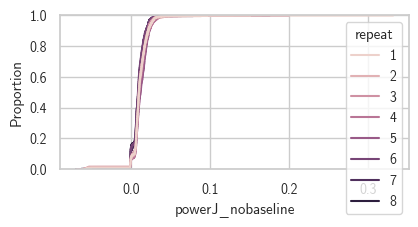

In [17]:
sns.ecdfplot(data=execs, x="powerJ_nobaseline", hue="repeat")

In [18]:
execs["duration_us"].groupby(execs["repeat"]).describe()

,count,mean,std,min,25%,50%,75%,max
repeat,,,,,,,,
1,682.0,40259.211312,61210.417499,17703.817,34984.81200,35965.432,37370.08425,1421667.768
2,687.0,37753.419086,20529.182900,17589.903,35096.55950,36163.002,37448.98800,402443.159
3,684.0,37997.731648,22185.743101,27648.517,35017.49475,35850.981,37349.71300,533000.338
4,685.0,38709.219714,27654.951178,24159.143,35081.66000,36120.298,37500.79100,564355.064
5,682.0,37894.759337,34965.529340,17801.771,34802.67450,35889.585,37268.30725,790604.719
6,683.0,36811.205643,20683.821245,17761.062,34818.14550,35679.316,37017.42850,489487.716
7,573.0,37956.615267,38584.166098,17696.350,34499.52400,35311.312,36845.36800,759358.283
8,683.0,35804.938978,10232.029089,17605.649,34325.95900,35489.519,36713.15850,264879.979


In [19]:
execs["powerJ_nobaseline"].groupby(execs["repeat"]).describe()

,count,mean,std,min,25%,50%,75%,max
repeat,,,,,,,,
1,682.0,0.012348,0.017237,-0.057839,0.007578,0.010592,0.016212,0.331434
2,687.0,0.011544,0.014126,-0.060120,0.007490,0.010257,0.016004,0.199170
3,684.0,0.011365,0.011988,-0.067880,0.007501,0.010576,0.015926,0.129490
4,685.0,0.012633,0.013428,-0.060252,0.008058,0.010918,0.017183,0.164730
5,682.0,0.013562,0.014376,-0.059880,0.008178,0.012579,0.018623,0.199751
6,683.0,0.009556,0.012094,-0.058206,0.006372,0.009283,0.013458,0.175317
7,573.0,0.010836,0.010635,-0.000949,0.006536,0.009526,0.014681,0.175541
8,683.0,0.009896,0.010716,-0.068839,0.006471,0.009573,0.014583,0.098548
